<a href="https://colab.research.google.com/github/rgolds5/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Richard_Goldsmith___LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
dir(random)  # Reminding ourselves what we can do here

In [0]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

In [0]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

In [0]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

In [0]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [12]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd

persons = pd.read_csv('https://raw.githubusercontent.com/rgolds5/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col = 0)

persons.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [13]:
persons.describe()

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


In [14]:
persons.isnull().sum()

age              0
weight           0
exercise_time    0
dtype: int64

In [18]:
persons.dtypes

age              int64
weight           int64
exercise_time    int64
dtype: object

In [27]:
persons.corr()

,age,weight,exercise_time
age,1.000000,0.144168,-0.273818
weight,0.144168,1.000000,-0.478021
exercise_time,-0.273818,-0.478021,1.000000


In [53]:
persons['age_bins'] = pd.cut(persons['age'], [18, 35, 50, 65, 80], right = False)
#weight_bins = pd.cut(persons['weight'], 4)
#exercise_time_bins = pd.cut(persons['exercise_time'], 4)

persons.groupby('age_bins')[['weight','exercise_time']].corr()


weight  exercise_time
age_bins                                       
[18, 35) weight         1.000000      -0.508694
         exercise_time -0.508694       1.000000
[35, 50) weight         1.000000      -0.531270
         exercise_time -0.531270       1.000000
[50, 65) weight         1.000000      -0.476621
         exercise_time -0.476621       1.000000
[65, 80) weight         1.000000      -0.288249
         exercise_time -0.288249       1.000000

In [55]:
persons['weight_bins'] = pd.cut(persons['weight'], 4)

persons.groupby('weight_bins')[['age', 'exercise_time']].corr()

age  exercise_time
weight_bins                                           
(99.854, 136.5] age            1.000000      -0.310056
                exercise_time -0.310056       1.000000
(136.5, 173.0]  age            1.000000      -0.279109
                exercise_time -0.279109       1.000000
(173.0, 209.5]  age            1.000000      -0.067808
                exercise_time -0.067808       1.000000
(209.5, 246.0]  age            1.000000       0.093683
                exercise_time  0.093683       1.000000

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

The variable types with this data would be dependent upon what you are testing. For example, if I were wanting to test the effect that exercise_time had on an individuals weight, then weight would be the dependent variable, exercise_time would be the independent variable, and age would be a control variable. 

2.  What are the relationships between the variables?

Age and weight have a weak positive correlation.
Age and exercise_time have a weak negative correlation.
Weight and exercise_time have a moderate negative correlation.

When we begin to break down the data, we can start to see differences in the relationships. As a person gets older, the negative correlation between their weight and exercise_time becomes weaker. We also see that as weight increases, we start with a moderate-to-weak negative correlation between age and exercise_time and end with practically no significant correlation.

3.  Which relationships are "real", and which spurious?

Because both age and weight demonstate weak to moderate correlations with exercise_time, and the difference in the correlations they demonstrate is not insignificant (to the naked eye without running any significance testing), we cannot rule out that there either are confounding variables. Both variables should be included in further testing. Age is of particular interest to be a confounding variable due to the high variance in it's correlation among weight groups.

## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)

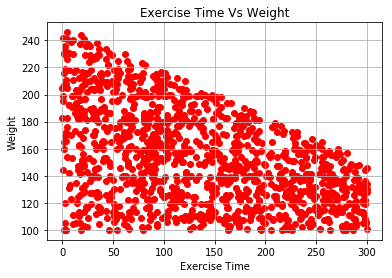

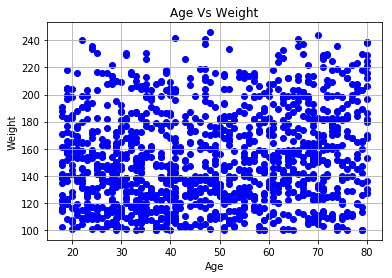

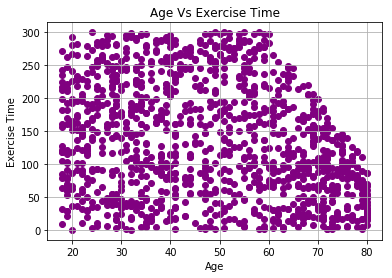

In [62]:
import matplotlib.pyplot as plt

plt.scatter(persons['exercise_time'], persons['weight'], color = 'red')
plt.title('Exercise Time Vs Weight')
plt.xlabel('Exercise Time')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

plt.scatter(persons['age'], persons['weight'], color = 'blue')
plt.title('Age Vs Weight')
plt.xlabel('Age')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

plt.scatter(persons['age'], persons['exercise_time'], color = 'purple')
plt.title('Age Vs Exercise Time')
plt.xlabel('Age')
plt.ylabel('Exercise Time')
plt.grid(True)
plt.show()

In [66]:
from sklearn import linear_model
import statsmodels.api as sm

X = persons[['age', 'exercise_time']]
Y = persons['weight']

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

model.summary()

Intercept: 
 178.463777274025
Coefficients: 
 [ 0.02775775 -0.19469398]


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 weight   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     177.5
Date:                Wed, 01 May 2019   Prob (F-statistic):           3.20e-68
Time:                        04:07:53   Log-Likelihood:                -5817.4
No. Observations:                1200   AIC:                         1.164e+04
Df Residuals:                    1197   BIC:                         1.166e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           178.4638      3.319     53.777      0.000     171.953     184.975
age               0.0278      0.051      0.544      0.587      -0.072       0.128
exercise_time    -0.1947      0.011    -17.963      0.000      -0.216      -0.173
==============================================================================
Omnibus:                       54.092   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.705
Skew:                          -0.116   Prob(JB):                     4.32e-06
Kurtosis:                       2.336   Cond. No.                         612.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""